## Kütüphanelerin Eklenmesi

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import (Dataset,DataLoader)
from skimage import io 

import warnings
warnings.filterwarnings("ignore")

## Verinin Dahil Edilmesi

In [2]:
class Veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file,encoding='latin1')
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self. transform(image)
        
        return (image,y_label)

## Veri Arttırma

In [ ]:
# transforms.Compose metodunu kullanarak veri setimiz için yeni veriler üretilebilmektedir.

## Veriyi Hazırlama

In [40]:
dataset = Veri(csv_file=r"C:\\Users\\mehme\\OneDrive\\Masaüstü\\f1_classification\\f111.csv",
               root_dir =r"C:\\Users\\mehme\\OneDrive\\Masaüstü\\f1_classification",
               transform = transforms.Compose([
                transforms.ToTensor(), # Tensor yapısına çeviriyoruz.
                transforms.Resize(size=(28,28)), # 1920,1080 olan fotoğraflarımızın boyutunu 28 piksele indirgiyoruz.
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Bu değerleri bilmiyorsanız 0.5 olarak bırakabiliriz. (Dokümantasyonu okunması tavsiye edilmektedir.)

               ])) # Birden fazla dönüşümü tek bir yapı altında toplayabiliyoruz.   

In [49]:
dataset

In [41]:
train_set,test_set = torch.utils.data.random_split(dataset,[200,79]) # Eğitim ve test verilerini random olarak ayrıştırıyoruz.

train_loader = DataLoader(dataset=train_set,batch_size=1,shuffle=False) # loader işlemlerini gerçekleştriyoruz. batch_size derğerimizi belirliyoruz.
test_loader = DataLoader(dataset=test_set,batch_size=1,shuffle=False) # loader bileşenini kullanarak modelimizi besleyeceğiz.

## Veriyi Görselleştirme

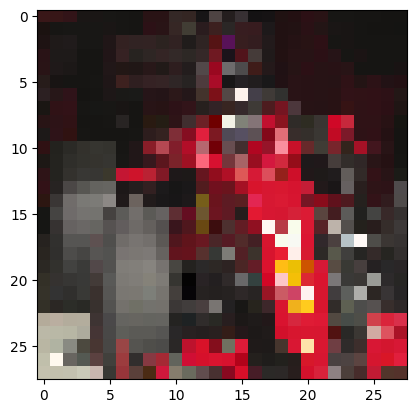

Ferrari
torch.Size([1, 3, 28, 28])


In [5]:
batch_size = 1
classes = ["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = data_iter.next()

imshow(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

## Model Mimarisini Oluşturma(Functional)

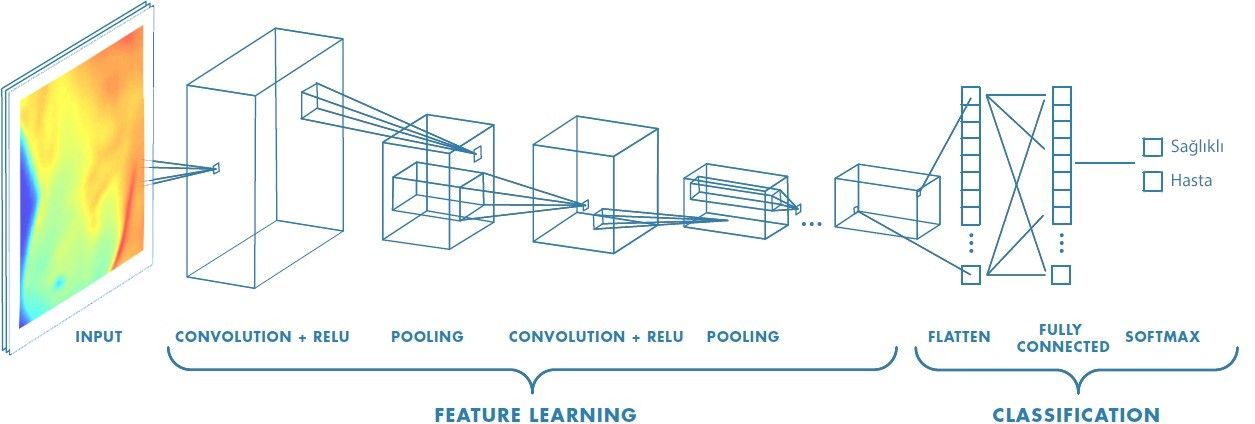

In [72]:
from IPython.display import Image 
pil_img = Image(filename='C:\\Users\\mehme\\OneDrive\\Masaüstü\\CNN.jpeg')
display(pil_img)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # in_channels = giriş kanalı(RGB),
        # channels = bu evrişimsel katmana kaç tane filtre uygulanacağı sayısı
        # kernel_size = uygulanacak olan filtrenin kaça kaçlık bir matris olacağını belirtiyoruz.

        # Convolution Katmanları
        # Convolution katmanına verilen görselin kaç piksele indirgendiği aşağıdaki şekilde hesaplanmaktadır.
        # (1 Görüntünün Piksel Değeri - Kernel_Size Değeri + 1)/(Pooling Kernel_Size Değeri)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 4, kernel_size=(5,5)) # 
        self.conv2 = nn.Conv2d(in_channels=4, out_channels = 8, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(in_channels=8, out_channels = 16, kernel_size=(2,2))
        self.conv4 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=(2,2))

        # Pooling Katmanı
        self.max = nn.MaxPool2d(kernel_size=(2,2))

        # Aktivasyon Fonksiyonunu belirliyoruz.
        self.func = nn.ELU()
        self.func1 = nn.ReLU()

        # Lineer Katmanları
        self.ly1 = nn.Linear(in_features = 32, out_features= 50)
        self.ly2 = nn.Linear(in_features = 50, out_features= 50)
        self.ly3 = nn.Linear(in_features = 50, out_features= 100)
        self.ly4 = nn.Linear(in_features = 100, out_features= 4)

    # Oluşturduğumuz katmanları birbiriyle bağlıyoruz.
    def forward(self, input):

        # Convolution, Relu, Pooling
        conv1 = self.conv1(input)
        act = self.func(conv1)
        pool1 = self.max(act)
        # Katman sonucunda eldeki görselin piksel değeri = (28-5+1)/2 = 12

        # Convolution, Relu, Pooling
        conv2 = self.conv2(pool1)
        act = self.func(conv2)
        pool2 = self.max(act)
        # Katman sonucunda eldeki görselin piksel değeri = (12-3+1)/2 = 5

        # Convolution, Relu, Pooling
        conv3 = self.conv3(pool2)
        act = self.func(conv3)
        pool3 = self.max(act)
        # Katman sonucunda eldeki görselin piksel değeri = (5-2+1)/2 = 2

        # Convolution, Relu
        conv4 = self.conv4(pool3)
        act = self.func(conv4)
        # Katman sonucunda eldeki görselin piksel değeri = (2-2+1) = 1 piksel görüntüler yapay sinir ağına girdi olarak verilecektir.

        # Flatten
        flatten = act.view(act.size(0), -1)

        # Sinir ağına flatten haline getirilmiş verimizi girdi olarak veriyoruz.
        ly1 = self.ly1(flatten)
        act = self.func(ly1)

        ly2 = self.ly2(act)
        act = self.func(ly2)

        ly3 = self.ly3(act)
        act = self.func(ly3)

        output = self.ly4(act)
        return output

## Model Mimarisini Oluşturma(Sequential)

In [21]:
model_seq = nn.Sequential(
    # Convolution, Relu, Pooling
    nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),

    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2)),
    nn.ReLU(),

    # Flatten
    nn.Flatten(),

    # Sinir ağına flatten haline getirilmiş verimizi girdi olarak veriyoruz.
    nn.Linear(in_features=32,out_features=50),
    nn.ReLU(),

    nn.Linear(in_features=50,out_features=50),
    nn.ReLU(),

    nn.Linear(in_features=50,out_features=100),
    nn.ReLU(),

    nn.Linear(in_features=100,out_features=4)
)
model_seq

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=50, bias=True)
  (13): ReLU()
  (14): Linear(in_features=50, out_features=50, bias=True)
  (15): ReLU()
  (16): Linear(in_features=50, out_features=100, bias=True)
  (17): ReLU()
  (18): Linear(in_features=100, out_features=4, bias=True)
)

## Modelin Eğitilmesi

In [84]:
import time
start = time.time()

# Modelimizi çağırıyoruz.
model = Net() 

# Model optimizasyonu için kullanılacak olan algoritmamızı ve hiperparametre değerlerimizi belirliyoruz.
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001)
epoch = 10

# Kullanılacak olan Loss metodunu belirliyoruz.
error = torch.nn.CrossEntropyLoss()

# Model eğitimini başlatıyoruz.
for i in range(epoch):
    for j,(image,label) in enumerate (train_loader):
        # Türev değerlerimizi sıfırlıyoruz çünkü her döngüde ağırlıklar güncellenmesi için baştan türev alım işlemi uygulanmaktadır.
        optimizer.zero_grad()

        # Modelimize tüm image değerlerini vererek tahmin yapmasını istiyoruz.
        predict_output = model(image)

        # Modelin tahmin değerleriyle resimlerin gerçek etiket değerlerini karşılaştırarak loss değerimizi elde ediyoruz.
        loss = error(predict_output, label)

        # Kayıp değerimize göre sinir ağı üzerinde geriye yayılım uyguluyoruz.
        loss.backward()

        # Direk epoch adımına geçiyoruz.
        optimizer.step()

        # Batch_Size değeri 1 olduğundan her epoch 200 iterasyon sürecektir.
        # 1 Epoch = Tüm eğitim verisinin YSA üzerinden geçirilmesi = Batch_Size*İterasyon
        print(f"Epoch: {i+1}/{epoch}, İterasyon: {j+1}, Kayıp Değeri(Loss): {loss.item()}")

end = time.time()
print(f"Süre: {end-start}")

# Accuracy değerimiz artarken Loss değerimizin düşmesi gerekmektedir. (İyi bir model elde etmek için)

Epoch: 1/10, İterasyon: 1, Kayıp Değeri(Loss): 1.4941104650497437
Epoch: 1/10, İterasyon: 2, Kayıp Değeri(Loss): 1.3518116474151611
Epoch: 1/10, İterasyon: 3, Kayıp Değeri(Loss): 1.3722188472747803
Epoch: 1/10, İterasyon: 4, Kayıp Değeri(Loss): 1.4185514450073242
Epoch: 1/10, İterasyon: 5, Kayıp Değeri(Loss): 1.406956434249878
Epoch: 1/10, İterasyon: 6, Kayıp Değeri(Loss): 1.372117519378662
Epoch: 1/10, İterasyon: 7, Kayıp Değeri(Loss): 1.4953469038009644
Epoch: 1/10, İterasyon: 8, Kayıp Değeri(Loss): 1.496511459350586
Epoch: 1/10, İterasyon: 9, Kayıp Değeri(Loss): 1.4905246496200562
Epoch: 1/10, İterasyon: 10, Kayıp Değeri(Loss): 1.4762141704559326
Epoch: 1/10, İterasyon: 11, Kayıp Değeri(Loss): 1.3679680824279785
Epoch: 1/10, İterasyon: 12, Kayıp Değeri(Loss): 1.3641892671585083
Epoch: 1/10, İterasyon: 13, Kayıp Değeri(Loss): 1.3548191785812378
Epoch: 1/10, İterasyon: 14, Kayıp Değeri(Loss): 1.4397797584533691
Epoch: 1/10, İterasyon: 15, Kayıp Değeri(Loss): 1.4233759641647339
Epoch: 

## Transfer Learning ile Modelin Eğitilmesi

In [ ]:
import torchvision.models as models
start = time.time()

# Önceden eğitilmiş modellerin ağırlıklarını kullanmak için pretrained = True yapıyoruz.
# Modelin sadece katman yapısını kullanarak kendi modelimizi eğitmek istediğimizde tüm ağırlıkları sıfırlayabiliriz. 
transfer_model = models.densenet161(pretrained=True)

# Bizim için önemli olan hazır modelin son katmanı olan classifier katmanıdır. 
for param in transfer_model.parameters():
    param.requires_grad = False # Hazır modelimizdeki parametre değerlerini kaybetmemek için donduruyoruz.

transfer_model.classifier = nn.Sequential(
    # 2208 değeri hazır modelin son sinir ağı katmanına ait çıkış değeridir. 
    # Eklediğimiz katmanlar bu katmanlardan sonra gelecek şekilde eklenmektedir.
    nn.Linear(2208,1000),
    nn.ReLU(inplace= True),

    nn.Linear(1000,100),
    nn.ReLU(inplace= True),

    nn.Linear(100,50),
    nn.ReLU(inplace= True),

    nn.Linear(50,4)
)

error = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(),lr=0.001)

# Modelimize uygun veri veya verimize uygun modelimizi olsaydı daha iyi bir model elde edilebilirdi.
epoch = 1
count = 0
iteration = []

for i in range(epoch):
    for i,(images,labels) in enumerate(train_loader):
        output = transfer_model(images)
        loss = error(output,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if count % 20 == 0:
            iteration.append(count)
            print(f"İterasyon = {count}, Loss Değeri = {loss.item()}")

end = time.time()
print(f"Süre: {end - start}")

transfer_model

## Tensorboard Kullanılarak Modelin Eğitilmesi

In [10]:
# Tensorboard kullanarak farklı hiperparametre değerlerinde modelimizin doğruluk ve kayıp değerlerini gözlemleyebiliyoruz.
from itertools import product
from torch.utils.tensorboard import SummaryWriter

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

start = time.time()

# Modelimizi eğiteceğimiz farklı parametre değerlerini belirliyoruz.
parameter = dict(lr=[0.1,0.01,0.001],batch_size=[1,2])
parameter_values = [value for value in parameter.values()]

# Model eğitimimizi farklı parametre değerleriyle gerçekleştireceğiz.
for lr,batch_size in product(*parameter_values):
    model = Net()
    optimizer = optim.Adam(model.parameters(),lr=lr)
    error = torch.nn.CrossEntropyLoss()

    images,labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    # Tensorboard SummaryWriter metoduyla açılışını yapıyoruz.
    tensorboard = SummaryWriter(comment=f'batch_size={batch_size} lr={lr}')
    tensorboard.add_image('images',grid)
    tensorboard.add_graph(model,images)

    # Model eğtimimizi başlatıyoruz.
    for epoch in range(5):
        total_loss = 0
        total_correct = 0

        for i,(images,labels) in enumerate(train_loader):
            pred = model(images)
            loss = error(pred,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(pred,labels)
        
        tensorboard.add_scalar('Loss',total_loss,epoch)
        tensorboard.add_scalar('Accuracy',total_correct/len(train_set),epoch)
        tensorboard.add_scalar('Number Correct',total_correct,epoch)
        tensorboard.add_hparams(
            {"lr":lr, "batch_size":batch_size},
            {"accuracy": total_correct / len(train_set), "loss": total_loss})

        for name,param in model.named_parameters():
            tensorboard.add_histogram(name,param,epoch)
            tensorboard.add_histogram(f'{name}.grad',param.grad,epoch)
        
        print(f'Epoch = {epoch}, "Toplam Doğru = {total_correct}, Toplam Kayıp = {total_loss}')
    tensorboard.close()

end = time.time()
print(f"Süre = {end-start}")
# Tensboard çıktı değerlerin görüntülemek için kodun çalışmış olduğu aynı dizinde runs klasörü altına sonuç değerleri kaydedilmektedir.
# Command Prompt açarak runs klasörünün olduğu dizinde tensorvoard --logdir=runs komutunu çalıştırıyoruz. Bu şekilde tensorboard ekranına erişilmektedir.

Epoch = 0, "Toplam Doğru = 45, Toplam Kayıp = 54902.873530060984
Epoch = 1, "Toplam Doğru = 50, Toplam Kayıp = 639.8335587051697
Epoch = 2, "Toplam Doğru = 41, Toplam Kayıp = 689.9606554231141
Epoch = 3, "Toplam Doğru = 45, Toplam Kayıp = 738.3025676874677
Epoch = 4, "Toplam Doğru = 43, Toplam Kayıp = 770.5952004796709
Epoch = 0, "Toplam Doğru = 44, Toplam Kayıp = 37110489.70616317
Epoch = 1, "Toplam Doğru = 41, Toplam Kayıp = 3484.982884499493
Epoch = 2, "Toplam Doğru = 46, Toplam Kayıp = 1872.6506730140827
Epoch = 3, "Toplam Doğru = 43, Toplam Kayıp = 1811.011719705868
Epoch = 4, "Toplam Doğru = 47, Toplam Kayıp = 1764.8684146595933
Epoch = 0, "Toplam Doğru = 50, Toplam Kayıp = 349.27176624536514
Epoch = 1, "Toplam Doğru = 42, Toplam Kayıp = 440.45127862133086
Epoch = 2, "Toplam Doğru = 47, Toplam Kayıp = 383.5374765396118
Epoch = 3, "Toplam Doğru = 34, Toplam Kayıp = 387.8295756280422
Epoch = 4, "Toplam Doğru = 44, Toplam Kayıp = 320.9436482787132
Epoch = 0, "Toplam Doğru = 56, Topl

## Modelin Test Edilmesi

In [85]:
def accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for image,label in loader:
            # Eğitilmiş olan modelimizin doğruluk değerini hesaplıyoruz.
            predict_output = model(image)
            _,pred = predict_output.max(1)
            num_correct += (pred==label).sum()
            num_samples += pred.size(0)
        return (num_correct/num_samples)

# Hem eğitim hem de test verisi için modelimizin doğruluk değerini hesaplıyoruz. 
print(f"Train Accuracy = {accuracy(train_loader,model)}")
print(f"Test Accuracy = {accuracy(test_loader,model)}")

Train Accuracy = 0.7599999904632568
Test Accuracy = 0.746835470199585


### Modelin Eğitim Anında Test Edilmesi - Learning Rate Değerinin Kademeli Olarak Düşürülmesi - Modelin GPU Üzerinde Eğitilmesi

In [55]:
start = time.time()

# Modelimizi çağırıyoruz.
model = Net() 

## GPU üzerinde model eğitiminin gerçekleştirilmesi
device = torch.device("cuda")
model = model.to(device)

# Model optimizasyonu için kullanılacak olan algoritmamızı ve hiperparametre değerlerimizi belirliyoruz.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Adam optimizasyon algoritması bu veri set için daha iyi sonuç vermektedir.
epoch = 10

# Kullanılacak olan Loss metodunu belirliyoruz.
error = torch.nn.CrossEntropyLoss()

## Kademeli Learning Rate Azaltma işlemi
from torch.optim.lr_scheduler import StepLR
lr = StepLR(optimizer,step_size=2,gamma=0.7)

# Modelin eğitim anında test edilmesi için gerekli değişkenlerin tanımlanması
loss_list = []
count = 0
iteration_list = []
accuracy_list = []

for i in range(epoch):
    ## learning Rate değerini kademeli olarak azaltıyoruz.
    lr.step()
    print(f"Epoch: {i}, Learning Rate: {lr.get_lr()}")

    for j,(images,labels) in enumerate (train_loader):
        ## GPU üzerinde model eğtimi gerçekleştirilecekse image ve label değerlerinin de GPU üzerine alınması gerekmektedir.
        images = images.to(device)
        labels = labels.to(device)

        # Türev değerlerimizi sıfırlıyoruz çünkü her döngüde ağırlıklar güncellenmesi için baştan türev alım işlemi uygulanmaktadır.
        optimizer.zero_grad()

        # Modelimize tüm image değerlerini vererek tahmin yapmasını istiyoruz.
        predict_output = model(images)

        # Modelin tahmin değerleriyle resimlerin gerçek etiket değerlerini karşılaştırarak loss değerimizi elde ediyoruz.
        loss = error(predict_output, labels)

        # Kayıp değerimize göre sinir ağı üzerinde geriye yayılım uyguluyoruz.
        loss.backward()

        # Direk epoch adımına geçiyoruz.
        optimizer.step()

        count = count + 1

        # Her 100 iterasyonda modelin sahip olmuş olduğu ağırlıklar kullanılarak test işlemi gerçekleştirilmekte ve anlık olarak doğruluk ve kayıp değerleri ölçülmektedir.
        if count % 100 == 0:

            total = 0
            pred_true = 0
            pred_false = 0

            for image, label in test_loader:
                # GPU model eğitimi için device ayarlarını gerçekleştiriyoruz. 
                image = image.to(device)
                label = label.to(device)

                predict_output = model(image.float()) # float veri tipinde verilmezse float tensor hatası alınabilmektedir.
                pred = torch.max(predict_output.data,1)[1]
                total = total + len(label)

                pred_true += (pred == label).sum()
                pred_false += (pred != label).sum()
            
            accuracy = 100 * pred_true / float(total)
            accuracy_list.append(accuracy)
            mistake  = 100 * pred_false / float(total)

            loss_list.append(loss.data)
            iteration_list.append(count)

            print(f"İterasyon = {count}, Kayıp Değeri = {loss.data}, Doğruluk Değeri = {accuracy}, Hata Değeri = {mistake}")

end = time.time()
print(f"Süre: {end-start}")

Epoch: 0, Learning Rate: [0.001]
İterasyon = 100, Kayıp Değeri = 1.4663326740264893, Doğruluk Değeri = 35.44303894042969, Hata Değeri = 64.55696105957031
İterasyon = 200, Kayıp Değeri = 0.6011444926261902, Doğruluk Değeri = 41.772151947021484, Hata Değeri = 58.227848052978516
Epoch: 1, Learning Rate: [0.00049]
İterasyon = 300, Kayıp Değeri = 1.811131238937378, Doğruluk Değeri = 48.10126876831055, Hata Değeri = 51.89873504638672
İterasyon = 400, Kayıp Değeri = 1.4219048023223877, Doğruluk Değeri = 56.96202850341797, Hata Değeri = 43.0379753112793
Epoch: 2, Learning Rate: [0.0007]
İterasyon = 500, Kayıp Değeri = 0.7795129418373108, Doğruluk Değeri = 67.08860778808594, Hata Değeri = 32.91139221191406
İterasyon = 600, Kayıp Değeri = 0.4653737545013428, Doğruluk Değeri = 69.62025451660156, Hata Değeri = 30.37974739074707
Epoch: 3, Learning Rate: [0.000343]
İterasyon = 700, Kayıp Değeri = 0.1276998072862625, Doğruluk Değeri = 74.68354797363281, Hata Değeri = 25.316455841064453
İterasyon = 80

## Modelin Kaydedilmesi

In [89]:
# Modelimizi sadece ağırlıklarını da kaydedebiliriz.
# Modelimizin hem ağırlıklarını hem de katmanlarını beraber kaydedebiliriz. (PyTorch tarafından bu yöntem önerilmektedir.)

# Modelimizin tamamını kaydediyoruz.
torch.save(model,"model.pth")

# Modelimizin sadece ağırlıklarını kaydediyoruz.
torch.save(model.state_dict(),"model_weights.pth")

## Modelin Yüklenmesi

In [23]:
# Modelin geri yüklenmesi
model_loaded = torch.load("model.pth")

## Modelin Görselleştirilmesi

In [ ]:
# Kaydedilmiş ağırlıklar kullnılarak modelin geri yüklenmesi
model_weigted = Net()
model_weigted.load_state_dict(torch.load("model_weights.pth"))
model_weigted.eval()

In [102]:
# Summary metoduyla model mimarsinin görselleştirilmesi
from torchsummary import summary
summary(model,input_size=(3,28,28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            304
├─Conv2d: 1-2                            296
├─Conv2d: 1-3                            528
├─Conv2d: 1-4                            2,080
├─MaxPool2d: 1-5                         --
├─ELU: 1-6                               --
├─ReLU: 1-7                              --
├─Linear: 1-8                            1,650
├─Linear: 1-9                            2,550
├─Linear: 1-10                           5,100
├─Linear: 1-11                           404
Total params: 12,912
Trainable params: 12,912
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            304
├─Conv2d: 1-2                            296
├─Conv2d: 1-3                            528
├─Conv2d: 1-4                            2,080
├─MaxPool2d: 1-5                         --
├─ELU: 1-6                               --
├─ReLU: 1-7                              --
├─Linear: 1-8                            1,650
├─Linear: 1-9                            2,550
├─Linear: 1-10                           5,100
├─Linear: 1-11                           404
Total params: 12,912
Trainable params: 12,912
Non-trainable params: 0

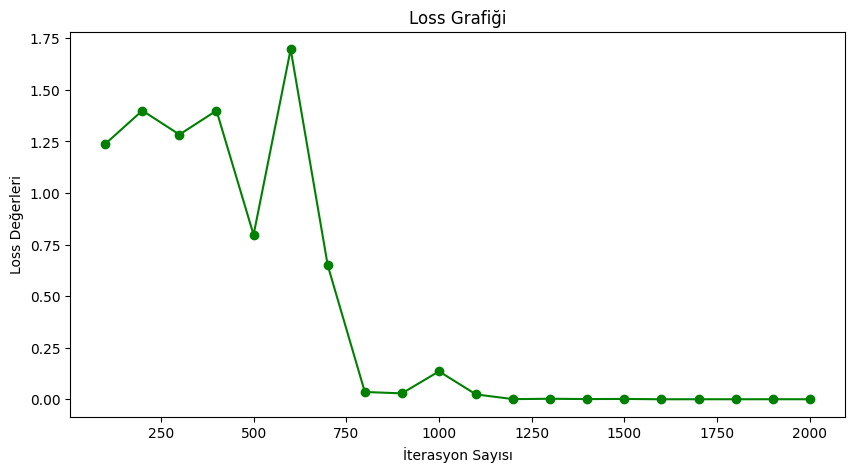

In [103]:
# Loss değerinin görselleştirilmesi

plt.figure(figsize=(10,5))
plt.title("Loss Grafiği")
plt.plot(iteration_list,loss_list,"-o", color = "g")

plt.xlabel("İterasyon Sayısı")
plt.ylabel("Loss Değerleri")
plt.show()

## Test Verisi Resimleri Üzerinden Tahmin Çalışması

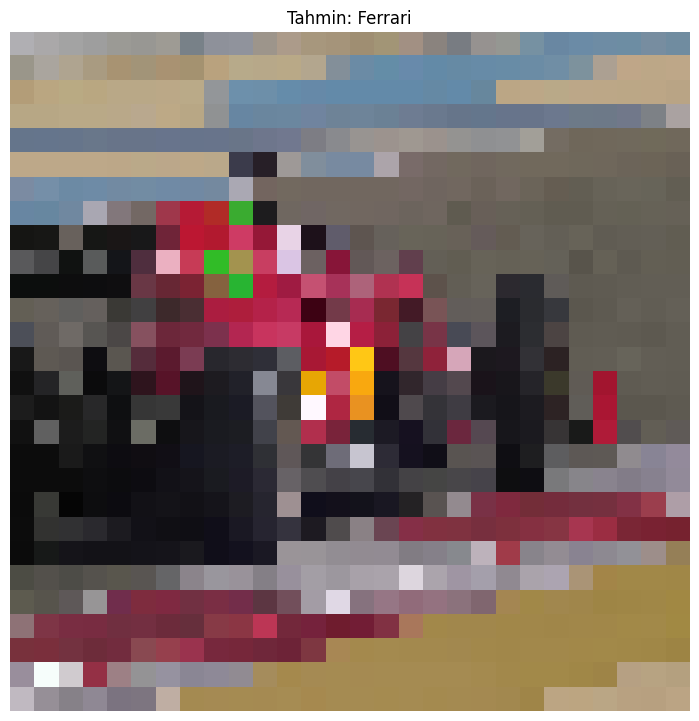

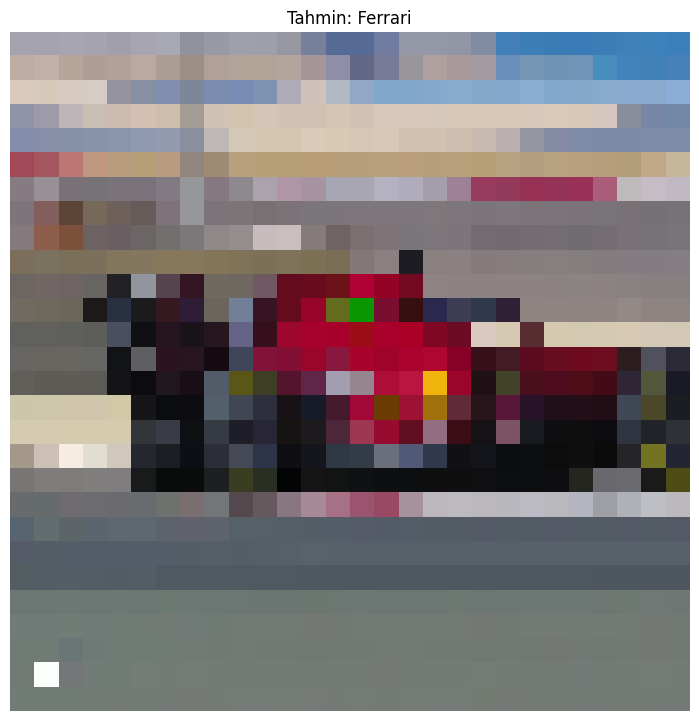

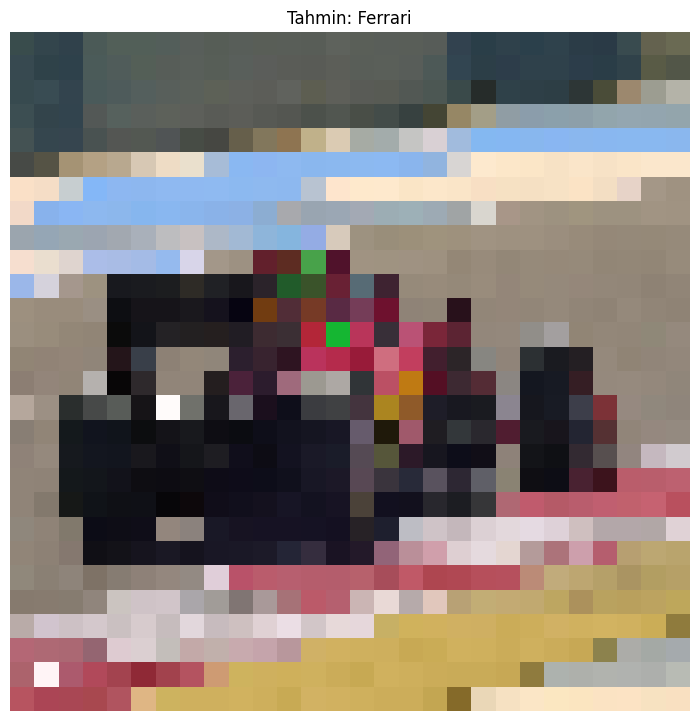

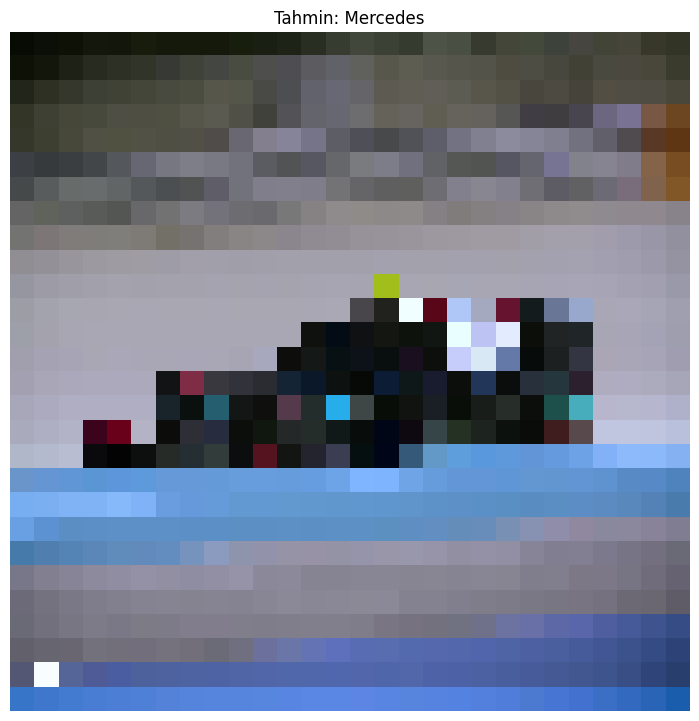

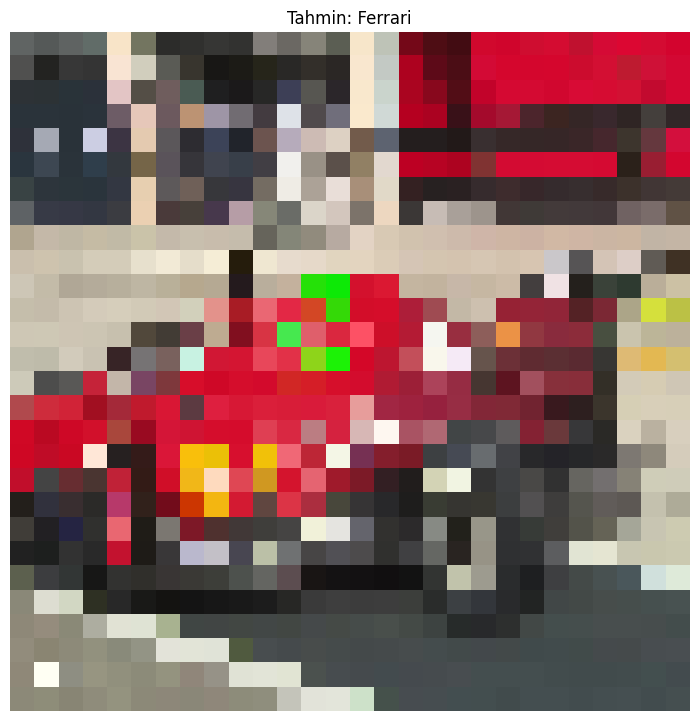

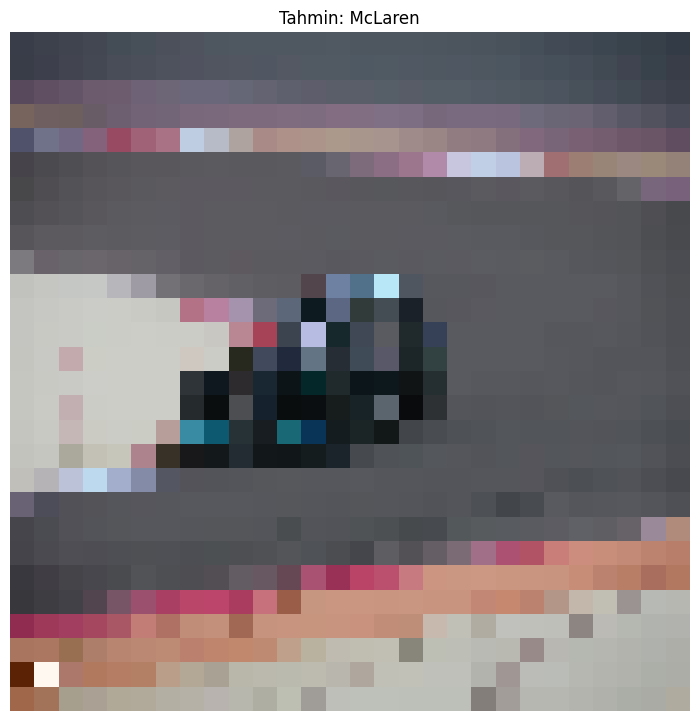

In [53]:
class_name = ["Ferrari","McLaren","Mercedes","Redbull"]

def display(model, image_number = 6):
    was_training = model.training
    model.eval() # Modelimizi değerlendirme durumuna ayarlıyoruz.
    img_number = 0
    with torch.no_grad():
        for i,(image,label) in enumerate(test_loader):
            predict_output = model(image)
            _,pred = torch.max(predict_output,1)

            for j in range(image.size()[0]):
                plt.figure(figsize=(40,30))
                img_number = img_number + 1
                ax = plt.subplot(image_number//2,2,img_number)
                ax.axis("off")
                ax.set_title(f"Tahmin: {class_name[pred[j]]}")

                ###############################################
                # T = transforms.Resize(size=(1920,1080))
                # show_image = T(image)
                # print(show_image.size())
                ###############################################
                
                imshow(image.cpu().data[j]) # Tüm parametre ve ara bellek değerlerimiz CPU'ya taşınmaktadır. Tensor ifadelerini vermektedir.

                if img_number == image_number:
                    model.train(mode=was_training)
                    return
display(model_loaded)